## Using trained model for unsupervised change detection

paper for the change detection idea https://arxiv.org/abs/1812.05815 which explains the whole difference image idea and how to do it with a unet architecture

In [3]:
from models import *


Segmentation Models: using `keras` framework.


In [4]:
unet_cd = unet_CD((256,256,3), (256,256,3))
#unet_cd.summary()

## Load weights from pretrained model into CD model

In [5]:
unet = load_model('ckpt/dckpt-19-landcover-0001', custom_objects={'iou_score': iou_score}, compile=False)

In [6]:
# verify the layers are correct and the same
unet_layer_names=[]
unet_ix = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35]
for i, ix in enumerate(unet_ix):
    unet_layer_names.append(unet.layers[ix].name)

In [7]:
# verify the layers are correct and the same
unet_cd_layer_names=[]
for layer in unet_cd.layers[:70]:
    unet_cd_layer_names.append(layer.name)

In [8]:
#unet_layer_names
len(unet_layer_names)

35

In [9]:
#unet_cd_layer_names
len(unet_cd_layer_names)

70

### Setting weights

In [10]:
# verify the layers are correct and the same
unet_layer_names=[]
unet_ix = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35]

# setting encoder weights for both inputs in CD
j = 0
for i, ix in enumerate(unet_ix):
    unet_cd.layers[j].set_weights(unet.layers[ix].get_weights())
    unet_cd.layers[j + 1].set_weights(unet.layers[ix].get_weights())
    j += 2

In [11]:
# layers i need from decoder architecture in CD model
decoder_indices_CD = [77, 79, 80, 81, 82, 83, 85, 87, 89, 91, 92, 93, 94, 95, 97, 99, 101,
                   103, 104, 105, 106, 107, 109, 111, 113, 115, 116, 117, 118, 119, 120, 121, 122]

In [12]:
# setting decoder weights for the decoder portion of the CD model
for i, ind in enumerate(decoder_indices_CD):
    unet_cd.layers[ind].set_weights(unet.layers[37:][i].get_weights())

## Demonstrate Change Detection on time-series of images

#### Preprocess input images

In [13]:
scaler = MinMaxScaler()

def preprocess_data_img(img):          
    
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = np.expand_dims(img, 0)
    
    return img

In [14]:
time_series_dir = os.path.join(os.getcwd(), 'timeseries')
time_series = os.listdir(os.path.join(os.getcwd(), 'timeseries'))
time_series_dir

'/home/jovyan/opt/SemanticSeg/timeseries'

In [15]:
time_series

['time02.png',
 'timeseries01.tif',
 '.ipynb_checkpoints',
 't1.tif',
 'timeseries02.tif',
 'time01.png',
 't2.tif']

In [16]:
prev_img = cv2.imread(os.path.join(time_series_dir,time_series[3]), 1)
curr_img = cv2.imread(os.path.join(time_series_dir,time_series[6]), 1)

In [17]:
p_img = preprocess_data_img(prev_img)
c_img = preprocess_data_img(curr_img)
print(p_img.shape)
print(c_img.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


## Making Change Predictions

In [18]:
unet_pred_1 = unet.predict(p_img)
unet_pred_2 = unet.predict(c_img)
unet_1_argmax = np.argmax(unet_pred_1, axis=3)
unet_2_argmax = np.argmax(unet_pred_2, axis=3)

In [19]:
test_pred = unet_cd.predict([p_img, c_img])
test_pred_argmax = np.argmax(test_pred, axis=3)

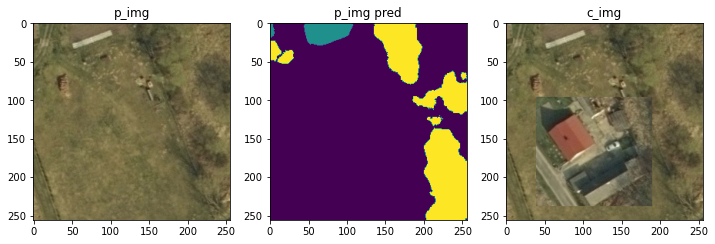

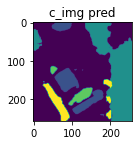

In [23]:
prev_img_color = cv2.cvtColor(prev_img, cv2.COLOR_BGR2RGB)
curr_img_color = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('p_img')
plt.imshow(prev_img_color)
plt.subplot(232)
plt.title('p_img pred')
plt.imshow(unet_1_argmax[0])
plt.subplot(233)
plt.title('c_img')
plt.imshow(curr_img_color)
plt.show()
plt.subplot(234)
plt.title('c_img pred')
plt.imshow(unet_2_argmax[0])
plt.show()

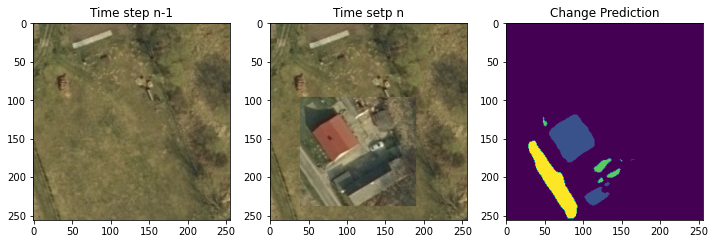

In [21]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Time step n-1')
plt.imshow(prev_img_color)
plt.subplot(232)
plt.title('Time step n')
plt.imshow(curr_img_color)
plt.subplot(233)
plt.title('Change Prediction')
plt.imshow(test_pred_argmax[0])
plt.show()